# Testing

(just load an input and watch the morphing)

In [1]:
import neurite as ne
import numpy as np
from notebooks.setup import test_generator, model, latest_checkpoint

Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


vxm info: mutual information loss is experimental


Eventually load the latest checkpoint

In [2]:
model.load_weights(latest_checkpoint)

In [3]:
import time
start = time.perf_counter()
model.evaluate(test_generator, return_dict=True)
total = time.perf_counter() - start
print(f"Took {total:.2f} seconds in total, {total / len(test_generator):.2f} seconds for each sample")

96/96 [==============================] - 109s 932ms/step - loss: -1.7615 - transformer_loss: -0.0412 - flow_resize_loss: 0.0116 - seg_transformer_loss: -0.8834 - transformer_mi: 0.0412 - seg_transformer_dice: 0.8834
Took 109.17401480000001 seconds in total, 1.1372293208333335 seconds for each sample


Qualitative test for prostate deformation

In [3]:
test_input, test_output, mr_targets, us_targets, _ = test_generator(10)
test_pred = model.predict(test_input)
# model.evaluate(test_input, test_output, return_dict=True)

In [ ]:
n_slice = 35
images = [img[0, :, :, n_slice * 2].squeeze() for img in [test_input[0], test_pred[0], test_input[1]]]
images += [img[0, :, :, n_slice].squeeze() for img in [test_input[2], test_pred[2], test_output[2]]]
titles = ['moving', 'moved', 'fixed', 'moving_seg', 'moved_seg', 'fixed_seg']
_ = ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, grid=(2, 3), width=12)

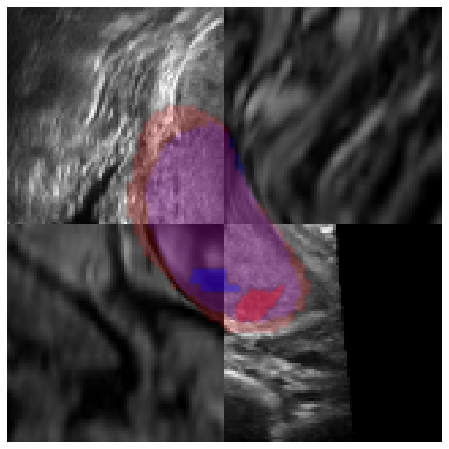

In [4]:
from skimage.transform import resize
import matplotlib.pyplot as plt

selector = 35

def compose_image(us_image, mr_image, us_seg, mr_seg, selector=50, four_by_four=False):
    # image
    n_slice_img = int(selector / 100.0 * us_image.shape[3])
    mr_image, us_image = [img[0, :, :, n_slice_img, 0] for img in [mr_image, us_image]]

    if four_by_four:
        overlapped = mr_image.copy()
        overlapped[0:40, 0:40] = us_image[0:40, 0:40]
        overlapped[0:40, 80:120] = us_image[0:40, 80:120]
        overlapped[40:80, 40:80] = us_image[40:80, 40:80]
        overlapped[40:80, 120:160] = us_image[40:80, 120:160]
        overlapped[80:120, 0:40] = us_image[80:120, 0:40]
        overlapped[80:120, 80:120] = us_image[80:120, 80:120]
        overlapped[120:160, 40:80] = us_image[120:160, 40:80]
        overlapped[120:160, 120:160] = us_image[120:160, 120:160]
    else:
        overlapped = mr_image.copy()
        overlapped[0:80, 0:80] = us_image[0:80, 0:80]
        overlapped[80:160, 80:160] = us_image[80:160, 80:160]

    # mask
    n_slice_mask = int(selector / 100 * us_seg.shape[3])
    mr_seg, us_seg = [resize(img[0, :, :, n_slice_mask, 0].astype(float), output_shape=(160, 160)) for img in [mr_seg, us_seg]]
    mask = np.zeros(shape=(us_seg.shape[0], us_seg.shape[1], 4))
    mask[:, :, 0] = us_seg
    mask[:, :, 2] = mr_seg
    mask = (mask > 0.5).astype(float)
    mask[:, :, 3] = np.bitwise_or(us_seg > 0.5, mr_seg > 0.5)

    return overlapped, mask, n_slice_img, n_slice_mask

overlapped, mask_seg, n_image_slice, _ = compose_image(test_output[0], test_pred[0], test_output[2], test_pred[2], selector)
_, mask_target, _, _ = compose_image(test_output[0], test_pred[0], us_targets[0][np.newaxis, ...], mr_targets[0][np.newaxis, ...], selector)

plt.figure(figsize=(8, 8))
plt.imshow(overlapped, cmap="gray", interpolation="nearest")
plt.imshow(mask_seg, alpha=0.20, interpolation='bicubic')
plt.imshow(mask_target, alpha=0.35, interpolation='bicubic')
plt.axis('off')
plt.show()

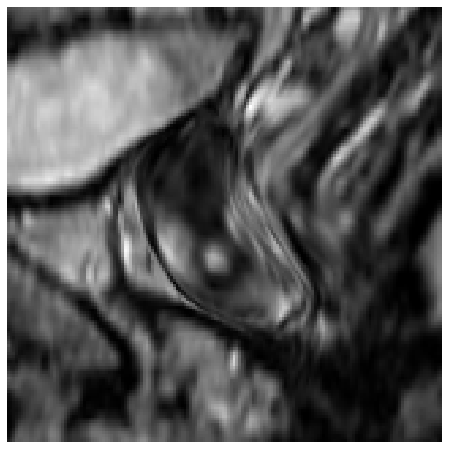

In [5]:
plt.figure(figsize=(8, 8))
plt.imshow(test_pred[0][0, ..., n_image_slice, 0], cmap="gray", interpolation="nearest")
plt.axis('off')
plt.show()

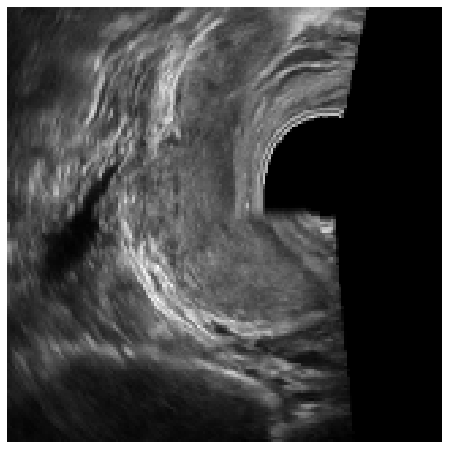

In [6]:
plt.figure(figsize=(8, 8))
plt.imshow(test_output[0][0, ..., n_image_slice, 0], cmap="gray", interpolation="nearest")
plt.axis('off')
plt.show()

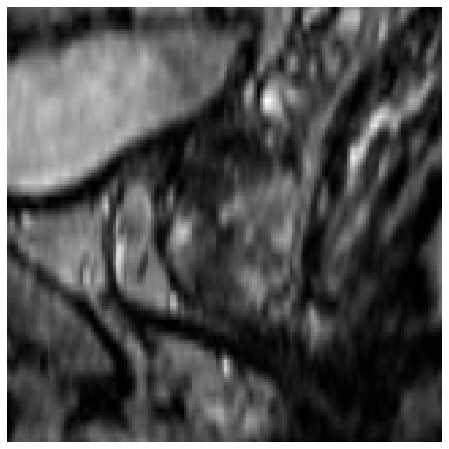

In [7]:
plt.figure(figsize=(8, 8))
plt.imshow(test_input[0][0, ..., n_image_slice, 0], cmap="gray", interpolation="nearest")
plt.axis('off')
plt.show()

Plot flow (doesn't work, some kind of resampling is needed)

In [ ]:
flow = test_pred[1].squeeze()
_ = ne.plot.flow([flow[:, :, i, [0,1]] for i in range(0, 80, 8)], width=25)

In [ ]:
# import k3d
#
# flow = test_pred[1].squeeze()
#
# plot = k3d.plot()
# plot += k3d.factory.vector_field(flow)
# plot.display()